In [11]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


## Data Loading
> - The data loading process involves reading multiple CSV files containing GPS, physical capability, priority areas, and recovery status data.
> - To ensure compatibility with different file encodings, a try and except block is used:
>   - **try Block:** Attempts to read the file using the default `utf-8` encoding.
>   - **except UnicodeDecodeError:** If a Unicode decoding error occurs, the file is re-read using the `latin1` encoding.
>   - **except Exception:** Catches any other unexpected errors and prints the error message for debugging purposes.
> - This approach ensures the files are loaded, this is needed as the team names for european teams contain characters not recognised by UTF-8 encoding

In [12]:
# Loading all data files
gps_fp = '/Users/jordanpickles/Library/CloudStorage/OneDrive-Personal/Personal Data Projects/Chelsea_Data_Project/Data/CFC GPS Data.csv'
priority_fp = '/Users/jordanpickles/Library/CloudStorage/OneDrive-Personal/Personal Data Projects/Chelsea_Data_Project/Data/CFC Individual Priority Areas.csv'
physical_fp = '/Users/jordanpickles/Library/CloudStorage/OneDrive-Personal/Personal Data Projects/Chelsea_Data_Project/Data/CFC Physical Capability Data_.csv'
recovery_fp = '/Users/jordanpickles/Library/CloudStorage/OneDrive-Personal/Personal Data Projects/Chelsea_Data_Project/Data/CFC Recovery Status Data.csv'

# Try reading the CSV file with different encodings
try:
    df_gps = pd.read_csv(gps_fp, encoding='utf-8')
except UnicodeDecodeError:
    df_gps = pd.read_csv(gps_fp, encoding='latin1')
except Exception as e:
    print(f"An error occurred: {e}")

try:
    df_priority = pd.read_csv(priority_fp, encoding='utf-8')
except UnicodeDecodeError:
    df_priority = pd.read_csv(priority_fp, encoding='latin1')
except Exception as e:
    print(f"An error occurred: {e}")

try:
    df_physical = pd.read_csv(physical_fp, encoding='utf-8')
except UnicodeDecodeError:
    df_physical = pd.read_csv(physical_fp, encoding='latin1')
except Exception as e:
    print(f"An error occurred: {e}")

try:
    df_recovery = pd.read_csv(recovery_fp, encoding='utf-8')
except UnicodeDecodeError:
    df_recovery = pd.read_csv(recovery_fp, encoding='latin1')
except Exception as e:
    print(f"An error occurred: {e}")

In [13]:
#inspecting df column names
print(df_gps.columns)
print(df_recovery.columns)
print(df_physical.columns)

Index(['date', 'opposition_code', 'opposition_full', 'md_plus_code',
       'md_minus_code', 'season', 'distance', 'distance_over_21',
       'distance_over_24', 'distance_over_27', 'accel_decel_over_2_5',
       'accel_decel_over_3_5', 'accel_decel_over_4_5', 'day_duration',
       'peak_speed', 'hr_zone_1_hms', 'hr_zone_2_hms', 'hr_zone_3_hms',
       'hr_zone_4_hms', 'hr_zone_5_hms'],
      dtype='object')
Index(['sessionDate', 'seasonName', 'metric', 'category', 'value'], dtype='object')
Index(['testDate', 'expression', 'movement', 'quality', 'benchmarkPct'], dtype='object')




## Data Cleaning / Wrangling of GPS Data
> - Converts time data in HMS to Seconds for easier calculations.
> - Combines high-intensity running and sprinting columns into a single metric for potential use in load analysis.
> - Ensures the `date` column is in the correct datetime format for consistency.
> - Creates a custom Match Day (MD) label to categorize training and match days.


In [14]:
#renaming the sprint columns and aadding a combined column for potential use in 
# high speed neuromuscular load and high intensity internal load

df_gps = df_gps.rename(columns={'distance_over_21': 'hsr_distance',
                                'distance_over_24': 'high_hsr_distance',
                                'distance_over_27': 'sprint_distance',
                                'distance':'total_distance',
                                'peak_speed':'top_speed'})

df_gps['combined_hsr_sprint'] = (df_gps['hsr_distance'].fillna(0) + df_gps['sprint_distance'].fillna(0))


# Converts hms data to seconds for easier calculations
hr_zones = [1, 2, 3, 4, 5]
for zone in hr_zones:
    hms_col = f'hr_zone_{zone}_hms'
    sec_col = f'hr_zone_{zone}_sec'
    
    df_gps[sec_col] = pd.to_timedelta(df_gps[hms_col], errors='coerce').dt.total_seconds()
    
df_gps['high_hr_seconds'] = df_gps['hr_zone_4_sec'] + df_gps['hr_zone_5_sec']
df_gps['high_hr_seconds'] = df_gps['high_hr_seconds'].fillna(0)

#ensures the date has the correct format
df_gps['date'] = pd.to_datetime(df_gps['date'], format='%d/%m/%Y')

# creating a combined MD label
df_gps['md_label'] = df_gps.apply(
    lambda row: '1' if row['md_plus_code'] == 1 else
                '2' if row['md_plus_code'] == 2 and row['md_minus_code'] < -6 else
                row['md_minus_code'] if row['md_minus_code'] >= -6 else
                None,
    axis=1)
df_gps.head(7)

,date,opposition_code,opposition_full,md_plus_code,md_minus_code,season,total_distance,hsr_distance,high_hsr_distance,sprint_distance,...,hr_zone_4_hms,hr_zone_5_hms,combined_hsr_sprint,hr_zone_1_sec,hr_zone_2_sec,hr_zone_3_sec,hr_zone_4_sec,hr_zone_5_sec,high_hr_seconds,md_label
0,2022-08-02,NaN,NaN,10,-4,2022/2023,4524.085076,89.278530,85.690318,61.634335,...,00:11:23,00:00:02,150.912866,220.0,1049.0,1160.0,683.0,2.0,685.0,-4
1,2022-08-03,NaN,NaN,10,-3,2022/2023,5264.645855,245.861691,91.348143,20.210588,...,00:06:08,00:00:01,266.072279,404.0,1000.0,935.0,368.0,1.0,369.0,-3
2,2022-08-04,NaN,NaN,10,-2,2022/2023,6886.542272,199.180260,84.634735,22.585470,...,00:06:30,00:00:02,221.765730,1049.0,2229.0,1429.0,390.0,2.0,392.0,-2
3,2022-08-05,NaN,NaN,10,-1,2022/2023,2622.552016,68.389321,11.795402,6.360193,...,00:01:51,00:00:00,74.749514,454.0,951.0,451.0,111.0,0.0,111.0,-1
4,2022-08-06,EVE,Everton,0,0,2022/2023,5654.028319,447.090545,164.576671,82.746430,...,00:13:15,00:02:30,529.836975,69.0,64.0,694.0,795.0,150.0,945.0,0
5,2022-08-07,NaN,NaN,1,-7,2022/2023,7379.419445,230.456378,76.865548,36.826599,...,00:05:43,00:00:04,267.282977,952.0,1945.0,999.0,343.0,4.0,347.0,1
6,2022-08-08,NaN,NaN,2,-6,2022/2023,0.000000,0.000000,0.000000,0.000000,...,00:00:00,00:00:00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-6



# Data Cleaning / Wrangling of Recovery Data
> - The recovery data is cleaned to ensure consistency and usability:
>   - The 'sessionDate' column is converted to a datetime format to align with the GPS data.
>   - Only rows with the category set to "total" are retained, as these represent the overall recovery scores.
>   - Column names are renamed for consistency with the GPS data, including renaming `sessionDate` to `date` and `value` to `recovery_score`.
>   - Unnecessary columns are dropped, keeping only `date` and `recovery_score` for further analysis.

In [15]:
# cleaning the recovery data - column names changed for consistency
# for this dashboard I am only interested in the recovery score and the date

df_recovery['sessionDate'] = pd.to_datetime(df_recovery['sessionDate'], format='%d/%m/%Y')
df_recovery_score = df_recovery[(df_recovery['category'] == 'total')].copy()

df_recovery_score = df_recovery_score.rename(columns={'sessionDate': 'date',
                                         'value':'recovery_score'})


df_recovery_score = df_recovery_score[['date', 'recovery_score']]
df_recovery_score.head()




,date,recovery_score
2,2023-07-02,NaN
15,2023-07-03,NaN
28,2023-07-04,0.0
41,2023-07-05,0.0
54,2023-07-06,0.0



# Joining GPS and Recovery Dataframes
> - The GPS and recovery dataframes are merged using a left join on the `date` column to ensure all GPS data is retained.
> - A new column, `is_recovery_data_collected`, is created to indicate whether recovery data is available for each date.
> - Missing recovery scores are filled with 0 in a new column, `recovery_score_filled`, for use in calculations.
> - A `recovery_label` column is added to categorize recovery scores into four groups:
>   - **No Data:** Recovery score is missing.
>   - **Normal:** Recovery score is 0.
>   - **Below Baseline:** Recovery score is negative.
>   - **Above Baseline:** Recovery score is positive.

In [16]:
## Merging the gps and recovery data frames
df_merged = df_gps.merge(df_recovery_score, on='date', how='left')
df_merged['is_recovery_data_collected'] = df_merged['recovery_score'].notnull().astype(bool)

df_merged['recovery_score_filled'] = df_merged['recovery_score'].fillna(0) # could be used in charting or rolling averages

conditions = [
    (df_merged['recovery_score'].isnull()),
    (df_merged['recovery_score'] == 0) ,
    (df_merged['recovery_score'] < 0.0),
    (df_merged['recovery_score'] > 0 )
]
choices = ['No Data', 'Normal', 'Below Baseline', 'Above Baseline']

df_merged['recovery_label'] = np.select(conditions, choices, default='Unknown')

df_merged.head()

,date,opposition_code,opposition_full,md_plus_code,md_minus_code,season,total_distance,hsr_distance,high_hsr_distance,sprint_distance,...,hr_zone_2_sec,hr_zone_3_sec,hr_zone_4_sec,hr_zone_5_sec,high_hr_seconds,md_label,recovery_score,is_recovery_data_collected,recovery_score_filled,recovery_label
0,2022-08-02,NaN,NaN,10,-4,2022/2023,4524.085076,89.278530,85.690318,61.634335,...,1049.0,1160.0,683.0,2.0,685.0,-4,NaN,False,0.0,No Data
1,2022-08-03,NaN,NaN,10,-3,2022/2023,5264.645855,245.861691,91.348143,20.210588,...,1000.0,935.0,368.0,1.0,369.0,-3,NaN,False,0.0,No Data
2,2022-08-04,NaN,NaN,10,-2,2022/2023,6886.542272,199.180260,84.634735,22.585470,...,2229.0,1429.0,390.0,2.0,392.0,-2,NaN,False,0.0,No Data
3,2022-08-05,NaN,NaN,10,-1,2022/2023,2622.552016,68.389321,11.795402,6.360193,...,951.0,451.0,111.0,0.0,111.0,-1,NaN,False,0.0,No Data
4,2022-08-06,EVE,Everton,0,0,2022/2023,5654.028319,447.090545,164.576671,82.746430,...,64.0,694.0,795.0,150.0,945.0,0,NaN,False,0.0,No Data



# Acute Chronic Workload
The acute-to-chronic workload ratio helps identify potential spikes in workload, which may increase the risk of injury or fatigue.

The following calculations are performed to analyze the acute and chronic workload:

- **EWMA (Exponentially Weighted Moving Average):** A short-term load metric calculated using a 7-day span to capture recent trends in workload.
$$
\text{EWMA}_t = \alpha \cdot x_t + (1 - \alpha) \cdot \text{EWMA}_{t-1}
$$

- **28-Day Rolling Average:** A chronic load metric calculated as the rolling average of the EWMA over a 28-day window.
$$
\text{28-day Average} = \frac{1}{28} \sum_{i=1}^{28} \text{EWMA}_{t-i}
$$

- **Delta Percentage:** The percentage difference between the acute (EWMA) and chronic (28-day rolling average) workload, providing insights into workload spikes or reductions.
$$
\Delta \% = \left( \frac{\text{EWMA}_t - \text{Avg}_{28}}{\text{Avg}_{28}} \right) \times 100
$$


These metrics are calculated for the following workload indicators:
- Total Distance
- High-Speed Running (HSR) Distance
- Accelerations/Decelerations over 2.5 m/s²
- High Heart Rate Seconds



In [17]:
df_merged = df_merged.sort_values(by='date', ascending=True)

ewma_span = 7
chronic_window = 28

metrics = {'total_distance' : 'ewma_total_distance',
           'hsr_distance' : 'ewma_hsr_distance',
           'accel_decel_over_2_5' : 'ewma_acc_dec_over_2_5',
           'high_hr_seconds' : 'ewma_high_hr_seconds'}

for current_col, ewma_col in metrics.items():
    df_merged[ewma_col] = df_merged[current_col].ewm(span=ewma_span, adjust=False).mean() #calculates short term load

    current_col = ewma_col + '_28d_avg'
    df_merged[current_col] = df_merged[ewma_col].rolling(window=chronic_window, min_periods=7).mean() #calculates chronic load

    delta_col = ewma_col + '_delta_pct'
    df_merged[delta_col] = ((df_merged[ewma_col] - df_merged[current_col]) / df_merged[current_col]) * 100 #calculates the acute chronic ratio

df_merged

,date,opposition_code,opposition_full,md_plus_code,md_minus_code,season,total_distance,hsr_distance,high_hsr_distance,sprint_distance,...,ewma_total_distance_delta_pct,ewma_hsr_distance,ewma_hsr_distance_28d_avg,ewma_hsr_distance_delta_pct,ewma_acc_dec_over_2_5,ewma_acc_dec_over_2_5_28d_avg,ewma_acc_dec_over_2_5_delta_pct,ewma_high_hr_seconds,ewma_high_hr_seconds_28d_avg,ewma_high_hr_seconds_delta_pct
0,2022-08-02,NaN,NaN,10,-4,2022/2023,4524.085076,89.278530,85.690318,61.634335,...,NaN,89.278530,NaN,NaN,119.108101,NaN,NaN,685.000000,NaN,NaN
1,2022-08-03,NaN,NaN,10,-3,2022/2023,5264.645855,245.861691,91.348143,20.210588,...,NaN,128.424321,NaN,NaN,100.824581,NaN,NaN,606.000000,NaN,NaN
2,2022-08-04,NaN,NaN,10,-2,2022/2023,6886.542272,199.180260,84.634735,22.585470,...,NaN,146.113305,NaN,NaN,99.990563,NaN,NaN,552.500000,NaN,NaN
3,2022-08-05,NaN,NaN,10,-1,2022/2023,2622.552016,68.389321,11.795402,6.360193,...,NaN,126.682309,NaN,NaN,85.930489,NaN,NaN,442.125000,NaN,NaN
4,2022-08-06,EVE,Everton,0,0,2022/2023,5654.028319,447.090545,164.576671,82.746430,...,NaN,206.784368,NaN,NaN,95.089898,NaN,NaN,567.843750,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,2025-04-07,NaN,NaN,1,-5,2024/2025,0.000000,0.000000,0.000000,0.000000,...,-99.679821,0.044357,14.964870,-99.703592,0.037694,12.717090,-99.703592,0.185394,62.546976,-99.703592
858,2025-04-08,NaN,NaN,2,-4,2024/2025,0.000000,0.000000,0.000000,0.000000,...,-99.706649,0.033268,11.223653,-99.703592,0.028271,9.537818,-99.703592,0.139046,46.910232,-99.703592
859,2025-04-09,NaN,NaN,3,-3,2024/2025,0.000000,0.000000,0.000000,0.000000,...,-99.717337,0.024951,8.417739,-99.703592,0.021203,7.153363,-99.703592,0.104284,35.182674,-99.703592
860,2025-04-10,NaN,NaN,4,-2,2024/2025,0.000000,0.000000,0.000000,0.000000,...,-99.703592,0.018713,6.313305,-99.703592,0.015902,5.365022,-99.703592,0.078213,26.387006,-99.703592


# Max Peak Speed in Dataset
> - Finds the maximum peak speed reached by the player during the current season (2024/2025) and stores it in a new column called `top_speed_max`. 
> - This value is added to each row in the season to allow comparison between daily peak speed and maximum peak speed, which is used later to assess readiness or exposure to top-end velocity.

In [18]:
# getting the top speed max recorded this season
current_season = '2024/2025'
df_current_season = df_merged[df_merged['season'] == current_season].copy()

# Getting max speed from top_speed column
top_speed_max = df_current_season['top_speed'].max()
print(f"Max top speed this season: {top_speed_max}")

# adding a coolumn for the top speed this season to all rows in the current season as this is the only data that will be used
df_merged.loc[df_merged['season'] == current_season, 'top_speed_max'] = top_speed_max


df_merged.tail(50)

Max top speed this season: 32.7274


,date,opposition_code,opposition_full,md_plus_code,md_minus_code,season,total_distance,hsr_distance,high_hsr_distance,sprint_distance,...,ewma_hsr_distance,ewma_hsr_distance_28d_avg,ewma_hsr_distance_delta_pct,ewma_acc_dec_over_2_5,ewma_acc_dec_over_2_5_28d_avg,ewma_acc_dec_over_2_5_delta_pct,ewma_high_hr_seconds,ewma_high_hr_seconds_28d_avg,ewma_high_hr_seconds_delta_pct,top_speed_max
812,2025-02-21,NaN,NaN,7,-1,2024/2025,4062.281285,113.931037,63.923846,38.758551,...,163.102773,270.545222,-39.713305,78.473804,102.050305,-23.102823,473.914345,621.284636,-23.720254,32.7274
813,2025-02-22,AVL,Aston Villa,0,0,2024/2025,5778.224429,235.079674,119.993327,51.721643,...,181.096998,263.683162,-31.320226,90.195036,101.355518,-11.011223,576.685758,614.490263,-6.152173,32.7274
814,2025-02-23,NaN,NaN,1,-2,2024/2025,4078.965587,140.363198,64.195485,14.875215,...,170.913548,259.789859,-34.210847,88.766604,101.588725,-12.621598,532.264319,612.956983,-13.164491,32.7274
815,2025-02-24,NaN,NaN,2,-1,2024/2025,3070.202878,25.043841,0.000000,14.906344,...,134.446121,255.385293,-47.355574,90.750802,101.456500,-10.552007,574.198239,607.557023,-5.490642,32.7274
816,2025-02-25,SOU,Southampton,0,0,2024/2025,12338.870350,833.673032,389.370378,136.419941,...,309.252849,259.525377,19.160929,138.456876,103.871394,33.296446,774.398679,615.783839,25.758201,32.7274
817,2025-02-26,NaN,NaN,1,-8,2024/2025,0.000000,0.000000,0.000000,0.000000,...,231.939637,257.196617,-9.820106,103.842657,104.367830,-0.503194,580.799010,610.712879,-4.898189,32.7274
818,2025-02-27,NaN,NaN,2,-7,2024/2025,7405.115670,473.583620,102.112319,17.274605,...,292.350633,253.716983,15.227065,125.340285,104.777617,19.625058,777.599257,606.115016,28.292360,32.7274
819,2025-02-28,NaN,NaN,3,-6,2024/2025,7370.235490,407.789228,40.610977,17.519842,...,321.210282,253.135963,26.892393,117.680404,104.732675,12.362646,867.199443,609.523762,42.274920,32.7274
820,2025-03-01,NaN,NaN,4,-5,2024/2025,0.000000,0.000000,0.000000,0.000000,...,240.907711,251.533886,-4.224550,88.260303,103.372271,-14.618976,650.399582,604.830322,7.534222,32.7274
821,2025-03-02,NaN,NaN,5,-4,2024/2025,0.000000,0.000000,0.000000,0.000000,...,180.680783,249.004258,-27.438677,66.195228,101.488683,-34.775755,487.799687,596.962027,-18.286312,32.7274


In [19]:
# adding a readiness to perform flag based on the top speed, and hsr and accel decel ewma
# set the flag to 'Ready' by default
df_merged['readiness_flag'] = 'Ready'

# Load spike
load_spike = (
    (df_merged['ewma_hsr_distance_delta_pct'] > 20) |
    (df_merged['ewma_acc_dec_over_2_5_delta_pct'] > 20)
)


# Moderate load increase
moderate_spike = (
    (df_merged['ewma_hsr_distance_delta_pct'].between(10, 20, inclusive='right')) |
    (df_merged['ewma_acc_dec_over_2_5_delta_pct'].between(10, 20, inclusive='right'))
)

# Recovery Below Baseline
recovery_low = (df_merged['recovery_score'] < -0.1)

# not achieving top speed
reduced_top_speed = df_merged['top_speed'] < 0.95 * df_merged['top_speed_max']

#Reduced on MD-1 or MD-2 
condition_reduced_strict = (
    df_merged['md_label'].astype(str).isin(['-1', '-2']) &
    (moderate_spike | reduced_top_speed | recovery_low) ## takes in speed as a metric to ensure ready to perform as MD-1 and MD-2 are the most important
)

# Reduced readiness on MD-3 to MD-6
condition_reduced_normal = (
    df_merged['md_label'].astype(str).isin(['-3', '-4', '-5', '-6']) &
    (load_spike | recovery_low)
)

# Condition should be monitored
condition_monitor = (
    df_merged['md_label'].astype(str).isin(['-1', '-2', '-3', '-4', '-5', '-6']) &
    (moderate_spike | (~condition_reduced_strict &~condition_reduced_normal)
)
)

# Applying logic conditions to the df. If reduced_strict and reduced_normal are satisfied then 'Reduced' readiness, else monitor or remain as ready
df_merged.loc[condition_reduced_strict | condition_reduced_normal, 'readiness_flag'] = 'Reduced'
df_merged.loc[condition_monitor, 'readiness_flag'] = 'Monitor'

df_merged.tail(50)

,date,opposition_code,opposition_full,md_plus_code,md_minus_code,season,total_distance,hsr_distance,high_hsr_distance,sprint_distance,...,ewma_hsr_distance_28d_avg,ewma_hsr_distance_delta_pct,ewma_acc_dec_over_2_5,ewma_acc_dec_over_2_5_28d_avg,ewma_acc_dec_over_2_5_delta_pct,ewma_high_hr_seconds,ewma_high_hr_seconds_28d_avg,ewma_high_hr_seconds_delta_pct,top_speed_max,readiness_flag
812,2025-02-21,NaN,NaN,7,-1,2024/2025,4062.281285,113.931037,63.923846,38.758551,...,270.545222,-39.713305,78.473804,102.050305,-23.102823,473.914345,621.284636,-23.720254,32.7274,Reduced
813,2025-02-22,AVL,Aston Villa,0,0,2024/2025,5778.224429,235.079674,119.993327,51.721643,...,263.683162,-31.320226,90.195036,101.355518,-11.011223,576.685758,614.490263,-6.152173,32.7274,Ready
814,2025-02-23,NaN,NaN,1,-2,2024/2025,4078.965587,140.363198,64.195485,14.875215,...,259.789859,-34.210847,88.766604,101.588725,-12.621598,532.264319,612.956983,-13.164491,32.7274,Ready
815,2025-02-24,NaN,NaN,2,-1,2024/2025,3070.202878,25.043841,0.000000,14.906344,...,255.385293,-47.355574,90.750802,101.456500,-10.552007,574.198239,607.557023,-5.490642,32.7274,Reduced
816,2025-02-25,SOU,Southampton,0,0,2024/2025,12338.870350,833.673032,389.370378,136.419941,...,259.525377,19.160929,138.456876,103.871394,33.296446,774.398679,615.783839,25.758201,32.7274,Ready
817,2025-02-26,NaN,NaN,1,-8,2024/2025,0.000000,0.000000,0.000000,0.000000,...,257.196617,-9.820106,103.842657,104.367830,-0.503194,580.799010,610.712879,-4.898189,32.7274,Ready
818,2025-02-27,NaN,NaN,2,-7,2024/2025,7405.115670,473.583620,102.112319,17.274605,...,253.716983,15.227065,125.340285,104.777617,19.625058,777.599257,606.115016,28.292360,32.7274,Ready
819,2025-02-28,NaN,NaN,3,-6,2024/2025,7370.235490,407.789228,40.610977,17.519842,...,253.135963,26.892393,117.680404,104.732675,12.362646,867.199443,609.523762,42.274920,32.7274,Monitor
820,2025-03-01,NaN,NaN,4,-5,2024/2025,0.000000,0.000000,0.000000,0.000000,...,251.533886,-4.224550,88.260303,103.372271,-14.618976,650.399582,604.830322,7.534222,32.7274,Monitor
821,2025-03-02,NaN,NaN,5,-4,2024/2025,0.000000,0.000000,0.000000,0.000000,...,249.004258,-27.438677,66.195228,101.488683,-34.775755,487.799687,596.962027,-18.286312,32.7274,Monitor



# Injury Risk Score Calculation
> - The injury risk score is a composite metric designed to quantify the likelihood of injury based on workload, readiness, and recovery data.
> - The score is scaled between 0 and 1, where higher values indicate a greater risk of injury.
> - The following components contribute to the injury risk score:
>   - **Load Spike Penalty (40% weight):** Indicates high workload deltas, with additional penalties for match day labels (e.g., MD-1, MD-2).
>   - **Readiness Penalty (30% weight):** Accounts for reduced or monitored readiness flags, with reduced penalties for MD+ and MD-1 labels.
>   - **Recovery Penalty (30% weight):** Reflects negative recovery scores, with reduced penalties for MD+ and MD-1 labels.
> - The formula for the injury risk score is:
$$
\text{Injury Risk Score} = 0.4 \cdot \text{Load Spike Penalty} + 0.3 \cdot \text{Readiness Penalty} + 0.3 \cdot \text{Recovery Penalty}
$$
> - The score is clipped between 0 and 1 to ensure the value doesn't exceed 0.1.

In [20]:
# Calculating injury risk - aiming to create a score scaled 0 to 1
# EMWA Spikes weighted at 0.4 - High load deltas = increased stress
# Readiness flafs weighted at 0.3 - Reduced readiness = increased risk
# Recovery score weighted at 0.3 - recovery = decreased risk
# The higher the score the higher the risk

# Load spike flag
df_merged['load_spike_flag'] = (
    (df_merged['ewma_hsr_distance_delta_pct'] > 20) | 
    (df_merged['ewma_acc_dec_over_2_5_delta_pct'] > 20)
).astype(int)

# Load spike penalty
df_merged['load_spike_penalty'] = df_merged['load_spike_flag']
df_merged.loc[df_merged['md_label'].isin(['-1', '-2']), 'load_spike_penalty'] *= 1.5
df_merged.loc[df_merged['md_label'] == '1', 'load_spike_penalty'] = 0
df_merged.loc[df_merged['md_label'] == '2', 'load_spike_penalty'] *= 0.5

# Readiness penalty
df_merged['readiness_penalty'] = df_merged['readiness_flag'].map({
    'Ready': 0,
    'Monitor': 0.5,
    'Reduced': 1
})

df_merged.loc[df_merged['md_label'] == '1', 'readiness_penalty'] *= 0
df_merged.loc[df_merged['md_label'] == '+', 'readiness_penalty'] *= 0.5

# Recovery penalty
df_merged['recovery_penalty'] = df_merged['recovery_score'].apply(
    lambda x: abs(x) if pd.notnull(x) and x < 0 else 0
)
df_merged.loc[df_merged['md_label'] == '1', 'recovery_penalty'] = 0
df_merged.loc[df_merged['md_label'] == '2', 'recovery_penalty'] *= 0.5

# Final injury risk score (scaled 0–1)
df_merged['injury_risk_score'] = (
    0.4 * df_merged['load_spike_penalty'] +
    0.3 * df_merged['readiness_penalty'] +
    0.3 * df_merged['recovery_penalty']
).clip(0, 1)

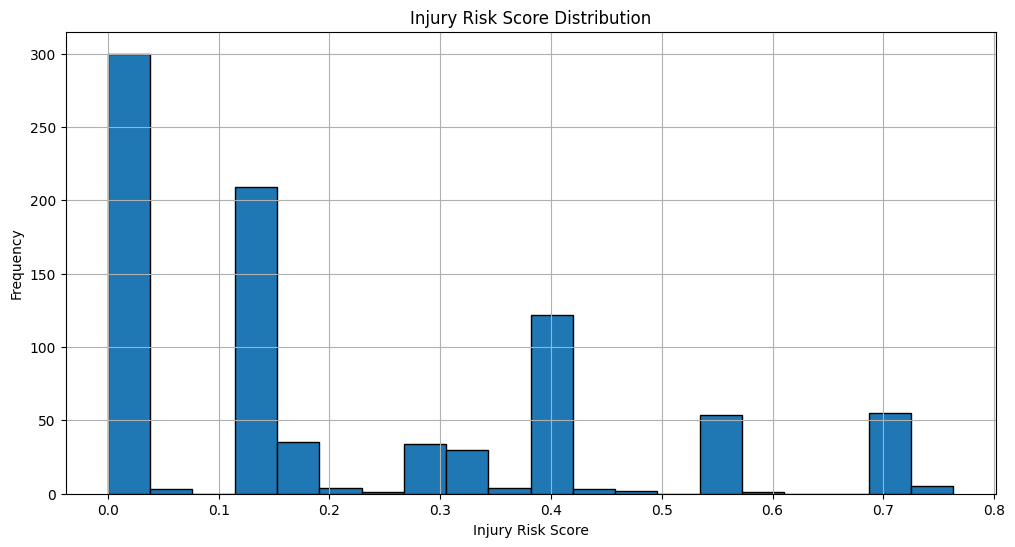

count    862.000000
mean       0.212930
std        0.217470
min        0.000000
25%        0.000000
50%        0.150000
75%        0.400000
90%        0.550000
95%        0.700000
max        0.763167
Name: injury_risk_score, dtype: float64

In [21]:
plt.figure(figsize=(12, 6))
df_merged['injury_risk_score'].hist(bins=20, edgecolor='black')
plt.title('Injury Risk Score Distribution')
plt.xlabel('Injury Risk Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

df_merged['injury_risk_score'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])


### Explanation of the Code
- **Assigning Injury Risk Flags:**
    - The injury risk score is categorized into three levels:
        - **Low Risk:** Injury risk score equals 0.0.
        - **Moderate Risk:** Injury risk score is between 0.01 and 0.4 (inclusive).
        - **High Risk:** Injury risk score is greater than 0.4.
    - These categories are based on the distribution of the injury risk scores, where the bottom 25% of the data occurs at 0.0 and the top 25% of the data occurs at 0.4 and above.
- **Implementation:**
    - A new column, `injury_risk_flag`, is created in the dataset.
    - The default value is set to "Low."
    - Rows with scores greater than 0.0 are updated to "Moderate."
    - Rows with scores greater than 0.4 are updated to "High."
    - The column is converted to a categorical data type for efficient storage and analysis.

In [22]:

df_merged['injury_risk_flag'] = 'Low' 
df_merged.loc[df_merged['injury_risk_score'] > 0.0, 'injury_risk_flag'] = 'Moderate'
df_merged.loc[df_merged['injury_risk_score'] > 4, 'injury_risk_flag'] = 'High'
df_merged['injury_risk_flag'] = df_merged['injury_risk_flag'].astype('category')


# Linear Regression Model for Recovery Score Prediction
> - A linear regression model is built to predict the recovery score for the next day based on various workload and recovery metrics.
> - The features used for the model include:
>   - Current recovery score
>   - Exponentially Weighted Moving Averages (EWMA) for total distance, high-speed running (HSR) distance, and accelerations/decelerations
>   - Percentage deltas for the above metrics
>   - Match day codes (MD+ and MD-)
> - The target variable is the recovery score for the next day, shifted by one row.
> - The dataset is split into training and testing sets, and the model's performance is evaluated using:
>   - Mean Squared Error (MSE)
>   - R² Score

### Results of Linear Regression
 > - r2 of 0.014 shows that there is very little insight in the predictve model despite there being little error from the mse score. 
 > - Having looked at the distribution of the data, the majority of the data is clustered around 0 with very little spread so the low r2 score is to be expected. 
 > - A classification model can now be tried

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# linear regression model to predict the recovery score for the next day

df_merged['recovery_score_next_day'] = df_merged['recovery_score'].shift(-1) # shift the recovery score up by 1 row to show the next days recovery

# collects features for the model

features = [
    'recovery_score',
    'ewma_total_distance',
    'ewma_hsr_distance',
    'ewma_acc_dec_over_2_5',
    'ewma_total_distance_delta_pct',
    'ewma_hsr_distance_delta_pct',
    'ewma_acc_dec_over_2_5_delta_pct',
    'md_plus_code',
    'md_minus_code'
]

df_model = df_merged[features + ['recovery_score_next_day']].dropna()
X = df_model[features]
y = df_model['recovery_score_next_day']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 0.00795442245830155
R^2 Score: -0.6222814749520236



# Classification Model Data Preprocessing
> - The dataset is prepared for classification by creating a recovery_score_flag based on the recovery score values:
>   - **Low:** Recovery score less than -0.1.
>   - **Normal:** Recovery score between -0.1 and 0.1 (inclusive).
>   - **High:** Recovery score greater than 0.1.
> - Features used for classification include workload metrics, readiness penalties, and match day codes.
> - Rows with missing values are dropped to ensure data quality for model training.

In [24]:
conditions = [
    (df_merged['recovery_score'] < -0.1),
    (df_merged['recovery_score'].between(-0.1, 0.1, inclusive='both')),
    (df_merged['recovery_score'] > 0.1)
]

choices = ['Low', 'Normal', 'High']
df_merged['recovery_score_flag'] = np.select(conditions, choices, default='Unknown')

features = [
    'recovery_score',
    'ewma_total_distance',
    'ewma_hsr_distance',
    'ewma_acc_dec_over_2_5',
    'ewma_total_distance_delta_pct',
    'ewma_hsr_distance_delta_pct',
    'ewma_acc_dec_over_2_5_delta_pct',
    'readiness_penalty',
    'md_minus_code',
    'md_plus_code'
]

# Drop rows with missing values
df_class = df_merged[features + ['recovery_score_flag']].dropna()

X = df_class[features]
y = df_class['recovery_score_flag']


# Random Forest Classifier Model for Recovery Score Prediction
**Note:** The models used in this analysis are not optimized or hyperparameter-tuned, as the primary objective was to create a proof of concept for recovery score prediction.

> - A Random Forest Classifier is used to predict the recovery score category (Low, Normal, High) based on workload and recovery metrics.
> - The features used for the model include:
>   - Recovery score
>   - Exponentially Weighted Moving Averages (EWMA) for total distance, high-speed running (HSR) distance, and accelerations/decelerations
>   - Percentage deltas for the above metrics
>   - Readiness penalty
>   - Match day codes (MD+ and MD-)
> - The dataset is split into training and testing sets, and the model's performance is evaluated using:
>   - Classification Report
>   - Confusion Matrix
> - The model is also used to predict the recovery class for a specific future date, and the prediction is added to the dataset for further analysis.


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_class = RandomForestClassifier(random_state=42)
rf_class.fit(X_train, y_train)

y_pred = rf_class.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

## adding the prediction

prediction_rows = df_merged[df_merged['date']=='2025-03-11'].copy()

X_future = prediction_rows[features]

predicted_recovery_class = rf_class.predict(X_future)

prediction_rows['date'] = prediction_rows['date'] + pd.Timedelta(days=1)

df_merged.loc[X_future.index, 'recovery_class_predicted'] = predicted_recovery_class

prediction_date = prediction_rows['date'].values[0] + pd.Timedelta(days=1)
prediction_index = df_merged[df_merged['date'] == prediction_date].index

if not prediction_index.empty:
    df_merged.loc[prediction_index, 'recovery_class_predicted'] = predicted_recovery_class

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        11
      Normal       1.00      1.00      1.00        54

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65

Confusion Matrix:
[[11  0]
 [ 0 54]]


# Feature Importance Analysis
> - **Note:** The feature importance analysis can be used to tune the Random Forest model in the future. Since the model has not been hyperparameter-tuned, the results are not expected to be fully accurate.

> - The feature importance analysis provides insights into the relative contribution of each feature to the Random Forest model's predictions.
> - The top features identified include:
>   - **md_minus_code:** The match day minus code, which indicates the proximity to a match day, is the most significant feature.
>   - **ewma_total_distance:** The exponentially weighted moving average of total distance, reflecting recent workload trends.
>   - **recovery_score:** The recovery score, which measures the player's recovery status.
>   - **ewma_hsr_distance:** The exponentially weighted moving average of high-speed running distance.
>   - **ewma_acc_dec_over_2_5:** The exponentially weighted moving average of accelerations and decelerations over 2.5 m/s².



In [35]:

# Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_

# Combine feature names with their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance DataFrame
print(feature_importance_df)



                            Feature  Importance
10                    md_minus_code    0.443487
3               ewma_total_distance    0.093598
0                    recovery_score    0.076144
5                 ewma_hsr_distance    0.073255
7             ewma_acc_dec_over_2_5    0.071469
8   ewma_acc_dec_over_2_5_delta_pct    0.055621
4     ewma_total_distance_delta_pct    0.051542
6       ewma_hsr_distance_delta_pct    0.049060
9                      md_plus_code    0.046394
2                 injury_risk_score    0.031686
1                 readiness_penalty    0.007745



# Predicting Total Distance for Future Sessions

**Note:** The models used in this analysis are not optimized or hyperparameter-tuned, as the primary objective was to create a proof of concept for recovery score prediction.

> - This section focuses on predicting the total distance covered by players for the next day and two days ahead using machine learning models.
> - The following steps are performed:
>   - **Data Preparation:**
>     - The `total_distance` column is shifted to create target variables for the next day (`total_distance_next_day`) and two days ahead (`total_distance_+2_days`).
>     - Rows with missing values in the features are dropped to ensure data quality.
>   - **Feature Selection:**
>     - Features include recovery score, readiness penalty, injury risk score, and exponentially weighted moving averages (EWMA) for workload metrics.
>   - **Model Training:**
>     - Two models are trained for each target variable:
>       - Random Forest Regressor
>       - Linear Regression
>     - The dataset is split into training and testing sets, and the models are evaluated using:
>       - R² Score
>       - Mean Squared Error (MSE)
>   - **Prediction:**
>     - The trained Random Forest model is used to predict the total distance for a specific future date.
>     - The predictions are added to the dataset for further analysis.
> - **Results:**
>   - The performance of both models is compared, and the predicted distances are stored in new columns for visualization within the dashboard.

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


#Predicting the total load / distance
## colleting all the sessions with distance data and shifting the next day values so that they can be used for predictions
df_merged['total_distance_next_day'] = df_merged['total_distance'].shift(-1)
df_merged['total_distance_+2_days'] = df_merged['total_distance'].shift(-2)
df_distance = df_merged[df_merged['total_distance'].notna()].copy()

## Features for the model
features = [
    'recovery_score',
    'readiness_penalty',
    'injury_risk_score',
    'ewma_total_distance',
    'ewma_total_distance_delta_pct',
    'ewma_hsr_distance',
    'ewma_hsr_distance_delta_pct',
    'ewma_acc_dec_over_2_5',
    'ewma_acc_dec_over_2_5_delta_pct',
    'md_plus_code',
    'md_minus_code',
]  

target_config = {
    'total_distance_next_day': ('predicted_total_distance_next_day', 1),
    'total_distance_+2_days': ('predicted_total_distance_+2_days', 2)
}

# Make sure your DataFrame is sorted
df_merged = df_merged.sort_values('date').reset_index(drop=True)

# Filter rows with actual physical data
df_distance = df_merged[df_merged['total_distance'] > 0].copy()

for target, (pred_col, shift_days) in target_config.items():
    # Drop rows where the target (y) is NaN
    X = df_distance[features]
    y = df_distance[target]

    # Combine and drop NaNs together to keep alignment
    training_data = pd.concat([X, y], axis=1).dropna()

    # Re-split after dropping NaNs
    X_clean = training_data[features]
    y_clean = training_data[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)


    # Train Random Forest Model
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)

    # Train Linear Regression Model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_preds = lr_model.predict(X_test)

    # Evaluate model performance
    rf_mse = mean_squared_error(y_test, rf_preds)
    rf_r2 = r2_score(y_test, rf_preds)

    lr_mse = mean_squared_error(y_test, lr_preds)
    lr_r2 = r2_score(y_test, lr_preds)

    # Print Results
    print("Random Forest Results:")
    print(f"R² Score: {rf_r2:.3f}")
    print(f"Mean Squared Error: {rf_mse:.2f}\n")

    print("Linear Regression Results:")
    print(f"R² Score: {lr_r2:.3f}")
    print(f"Mean Squared Error: {lr_mse:.2f}")


    latest_row_with_data = df_merged[df_merged['date']=='2025-03-11'].copy()
   
    ## Model Prediction
    X_predict_data = latest_row_with_data[features]
    predicted_distance = rf_model.predict(X_predict_data)

    print(f'Predicted Distance : {target}: {predicted_distance[0]}')

        # Get future date to insert prediction into
    
    prediction_date = latest_row_with_data['date'].values[0] + pd.Timedelta(days=shift_days)
    print(prediction_date)
    prediction_index = df_merged[df_merged['date'] == prediction_date].index
    print(prediction_index)

    if not prediction_index.empty:
        df_merged.loc[prediction_index, pred_col] = predicted_distance
    
df_merged.tail(100)
    

Random Forest Results:
R² Score: 0.288
Mean Squared Error: 4125305.31

Linear Regression Results:
R² Score: 0.099
Mean Squared Error: 5225110.22
Predicted Distance : total_distance_next_day: 4203.846432949998
2025-03-12 00:00:00
Int64Index([831], dtype='int64')
Random Forest Results:
R² Score: 0.291
Mean Squared Error: 7313014.06

Linear Regression Results:
R² Score: -0.083
Mean Squared Error: 11166590.93
Predicted Distance : total_distance_+2_days: 8378.636016639999
2025-03-13 00:00:00
Int64Index([832], dtype='int64')


,date,opposition_code,opposition_full,md_plus_code,md_minus_code,season,total_distance,hsr_distance,high_hsr_distance,sprint_distance,...,recovery_penalty,injury_risk_score,injury_risk_flag,recovery_score_next_day,recovery_score_flag,recovery_class_predicted,total_distance_next_day,total_distance_+2_days,predicted_total_distance_next_day,predicted_total_distance_+2_days
762,2025-01-02,NaN,NaN,3,-2,2024/2025,4381.823964,86.573977,78.251231,18.627905,...,0.052536,0.315761,Moderate,0.026780,Normal,NaN,6754.054957,5794.546512,NaN,NaN
763,2025-01-03,NaN,NaN,4,-1,2024/2025,6754.054957,467.170880,113.690924,20.280872,...,0.000000,0.300000,Moderate,NaN,Normal,NaN,5794.546512,0.000000,NaN,NaN
764,2025-01-04,CRY,Crystal Palace,0,0,2024/2025,5794.546512,368.873409,150.610977,41.395441,...,0.000000,0.000000,Low,NaN,Unknown,NaN,0.000000,3483.833771,NaN,NaN
765,2025-01-05,NaN,NaN,1,-6,2024/2025,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,Low,-0.110184,Unknown,NaN,3483.833771,2858.404149,NaN,NaN
766,2025-01-06,NaN,NaN,2,-5,2024/2025,3483.833771,244.466481,171.200504,22.941776,...,0.110184,0.333055,Moderate,-0.032483,Low,NaN,2858.404149,6656.915887,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,2025-04-07,NaN,NaN,1,-5,2024/2025,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,Low,NaN,Unknown,NaN,0.000000,0.000000,NaN,NaN
858,2025-04-08,NaN,NaN,2,-4,2024/2025,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.150000,Moderate,NaN,Unknown,NaN,0.000000,0.000000,NaN,NaN
859,2025-04-09,NaN,NaN,3,-3,2024/2025,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.150000,Moderate,NaN,Unknown,NaN,0.000000,0.000000,NaN,NaN
860,2025-04-10,NaN,NaN,4,-2,2024/2025,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.300000,Moderate,NaN,Unknown,NaN,0.000000,NaN,NaN,NaN


# Feature Importance Analysis
> - The feature importance analysis provides insights into the relative contribution of each feature to the Random Forest model's predictions.
> - The top features identified include:
>   - **md_minus_code:** The match day minus code, indicating proximity to a match day, is the most significant feature.
>   - **ewma_total_distance:** The exponentially weighted moving average of total distance, reflecting recent workload trends.
>   - **recovery_score:** The recovery score, which measures the player's recovery status.
>   - **ewma_hsr_distance:** The exponentially weighted moving average of high-speed running distance.
>   - **ewma_acc_dec_over_2_5:** The exponentially weighted moving average of accelerations and decelerations over 2.5 m/s².
> - These insights can guide further model optimization and feature selection for improved performance.

                            Feature  Importance
10                    md_minus_code    0.443487
3               ewma_total_distance    0.093598
0                    recovery_score    0.076144
5                 ewma_hsr_distance    0.073255
7             ewma_acc_dec_over_2_5    0.071469
8   ewma_acc_dec_over_2_5_delta_pct    0.055621
4     ewma_total_distance_delta_pct    0.051542
6       ewma_hsr_distance_delta_pct    0.049060
9                      md_plus_code    0.046394
2                 injury_risk_score    0.031686
1                 readiness_penalty    0.007745


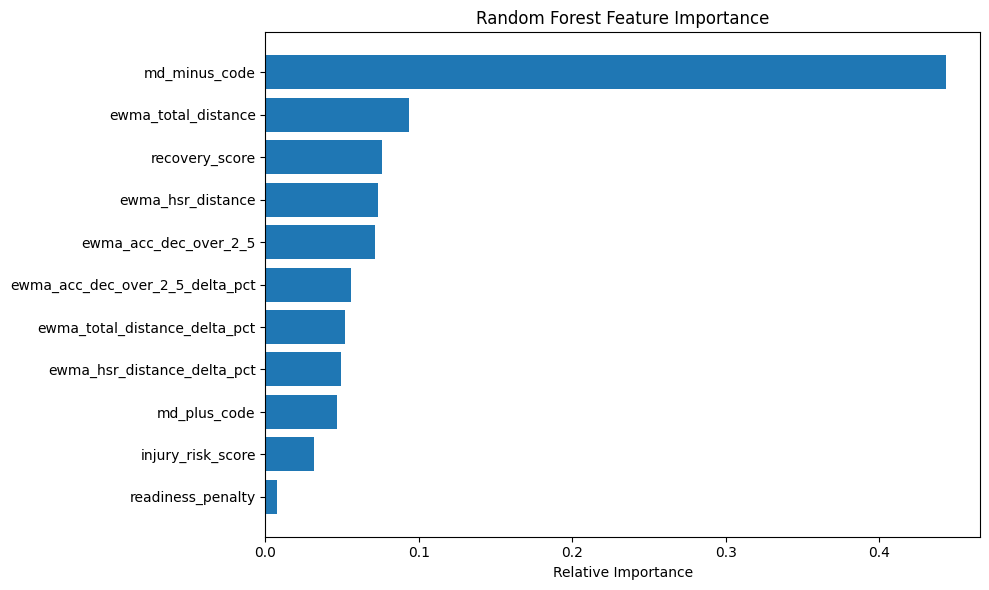

In [ ]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_

# Combine with feature names
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top features
print(feature_importance_df)



# Miscellaneous
> - This section adds additional columns to the dataset that can be utilized in the dashboard.
> - These columns include:
>   - **Week Commencing:** The Monday of each date to group data by weeks.
>   - **Season Week:** The week number within the season, calculated based on the first match date.
>   - **Games This Week:** The count of games (MD-0) in each season week.
>   - **28-Day EWMA Metrics:** Historical metrics shifted by 28 days for comparison and trend analysis.

In [ ]:


# 1. Calculate week_commencing (Monday of each date)
df_merged['week_commencing'] = df_merged['date'] - pd.to_timedelta(df_merged['date'].dt.weekday, unit='d')

# 2. Get first match date per season (MD-0), aligned to Monday
first_match_dates = (
    df_merged[df_merged['md_label'] == 0]
    .groupby('season')['date']
    .min()
    .apply(lambda d: d - pd.to_timedelta(d.weekday(), unit='d'))  # Snap to Monday
)

# 3. Map first match week to all rows
df_merged['season_start'] = df_merged['season'].map(first_match_dates)

# 4. Calculate season_week based on first match week
df_merged['season_week'] = (
    ((df_merged['date'] - df_merged['season_start']).dt.days // 7) + 1
)

# 5. Count games (MD-0) per season_week
games_per_week = (
    df_merged[df_merged['md_label'] == 0]
    .groupby(['season', 'season_week'])
    .size()
    .rename('games_this_week')
)

# 6. Merge game counts into main DataFrame
df_merged = df_merged.merge(games_per_week, on=['season', 'season_week'], how='left')

# 7. Clean nulls and convert to integer
df_merged['games_this_week'] = df_merged['games_this_week'].fillna(0).astype(int)

# 8. Optional week label for tooltips or subtitles
df_merged['week_label'] = (
    "Wk " + df_merged['season_week'].astype(str) +
    " (" + df_merged['games_this_week'].astype(str) + " Games)"
)

df_merged['ewma_total_distance_28d_ago'] = df_merged['ewma_total_distance'].shift(28)
df_merged['ewma_acc_dec_over_2_5_28d_ago'] = df_merged['ewma_acc_dec_over_2_5'].shift(28)
df_merged['ewma_hsr_distance_28d_ago'] = df_merged['ewma_hsr_distance'].shift(28)

df_merged.to_csv('/Users/jordanpickles/Library/CloudStorage/OneDrive-Personal/Personal Data Projects/Chelsea_Data_Project/Data/CFC Physical Performance Dashboard.csv', index=False)
